In [23]:
import re
import os
import sys
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from Bio import SeqIO, pairwise2, AlignIO
from collections import Counter, namedtuple
from Bio.Align import AlignInfo, MultipleSeqAlignment
importlib.reload(sys.modules['MultipleCutter'])
import importlib
from Sequence import Sequence
from Util.SeqUtil import seqInfo, parseFasta
from Evaluation.DfamEvaluation import DfamEvaluation
from DataStructure import PositionInfo, refSeqSimilarityInfo
from SharedInfo import currDatasetName, cutterA, cutterB, colorA, colorB
from Util.AnalysisUtil import listToSortedCounter, getStatisticData, mostCommonTable
from Util.PlotUtil import basicPlot, twoLabelBasicPlot, lengthScatterDistributionPlot
from MultipleCutter import MultipleCutter

In [3]:
currDatasetName = "chrX_dm6"

In [4]:
seqA = Sequence(cutterA)
parseFastaA = seqA.parseFasta()
fragmentLenListA, fragmentSeqListA = seqA.parseSeqByCutter()
repeatInfoListA = seqA.findRepeatSeqs(lengthLimit=True)
filterRepeatInfoA = seqA.filterRepeatInfo()
repeatPositionListA = seqA.getRepeatPositionList(filter=True)

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.15015888214111328 sec to parse fasta file ...
...start parse seq by cutter: GATC
...cost 0.33266472816467285 sec to cut sequence
... start finding repeat seq ...
...cost0.06346988677978516 sec to finding repeat seq  ...


In [5]:
seqB = Sequence(cutterB)
parseFastaB = seqB.parseFasta()
fragmentLenListB, fragmentSeqListB = seqB.parseSeqByCutter()
repeatInfoListB = seqB.findRepeatSeqs(lengthLimit=True)
filterRepeatInfoB = seqB.filterRepeatInfo()
repeatPositionListB = seqB.getRepeatPositionList(filter=True)

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.1461787223815918 sec to parse fasta file ...
...start parse seq by cutter: AAGCTT
...cost 0.347553014755249 sec to cut sequence
... start finding repeat seq ...
...cost0.006192207336425781 sec to finding repeat seq  ...


In [6]:
seqInfo(currDatasetName, parseFastaA)

chrX_dm6 dataset
 number of sequence:1
 total length:23542271



In [7]:
repeatPositionList = repeatPositionListA + repeatPositionListB

In [8]:
print(f'Check cutter A, B: \n {len(repeatPositionList)} = {len(repeatPositionListA)} + {len(repeatPositionListB)}')

Check cutter A, B: 
 3332 = 3202 + 130


In [9]:
repeatPositionList[0]

PositionInfo(startIdx=432, endIdx=647)

In [21]:
# repeat position
multipleCutter = MultipleCutter(chrLength=len(parseFastaA[0]),repeatPositionList = repeatPositionList )
seqStateList = multipleCutter.seqStateGenerator()
unMatchState, unionState, intersectionState = multipleCutter.getSeqStateInfo()

chr: 23542271
unMatch: 22698683, union:786347, intersection:57241


In [24]:
matchStateIdxList = multipleCutter.getSpecificStateIdxList(stateName="union")
matchStatePositionList = multipleCutter.getSpecificStatePositionList()

AttributeError: 'MultipleCutter' object has no attribute 'getSpecificStateIdxList'

In [57]:
textfile = open("seqState.txt", "w")
textfile.write(str(seqStateList))
textfile.close()

textfile = open("matchStatePosition.txt", "w")
for element in matchStatePositionList:
    textfile.write(str(element) + "\n")
textfile.close()

In [10]:
dfam = DfamEvaluation(repeatPositionList, hitFileName='chrX_LTR_dm6_dfam.nrph.hits')

In [11]:
repeatPositionLookupDic = dfam.positionBucketClassifier()
dfamPositionList = dfam.getDfamPositionList()

In [12]:
len(dfamPositionList)

602

In [13]:
# from Dfam , check repeat
DRrepeatMatchList, DRmatchedFamilyAccList, DRmatchedFamilyNameList = dfam.checkDfamMatchWithRepeat()

In [ ]:
# from repeat , check Dfam
# RDrepeatMatchList, RDmatchedFamilyAccList, RDmatchedFamilyNameList = dfam.checkRepeatMatchWithDfam()

In [14]:
len(DRrepeatMatchList)

602

In [15]:
# dfam.familyMatchRatio(DRmatchedFamilyAccList)
dfam.matchRatio(DRrepeatMatchList)
unMatchDf = dfam.getUnmatchInfo(DRrepeatMatchList)

matchCount:131	dfamCount:602	Ratio:0.21760797342192692
count     471.000000
mean      303.694268
std       152.665118
min        23.000000
25%       172.000000
50%       314.000000
75%       416.000000
max      1500.000000
dtype: float64


In [ ]:
# dfam.familyMatchRatio(RDmatchedFamilyAccList)
# dfam.matchRatio(RDrepeatMatchList)
# unMatchDf = dfam.getUnmatchInfo(RDrepeatMatchList)

Family Match Result:
matchCount:25	dfamCount:55	Ratio:0.45
unmatch acc: {'DF0001635', 'DF0001647', 'DF0001631', 'DF0001611', 'DF0001639', 'DF0001540', 'DF0001654', 'DF0001629', 'DF0001628', 'DF0001633', 'DF0001613', 'DF0001621', 'DF0001585', 'DF0001727', 'DF0001652', 'DF0001568', 'DF0001564', 'DF0001667', 'DF0001626', 'DF0001560', 'DF0001709', 'DF0001570', 'DF0001673', 'DF0001547', 'DF0001566', 'DF0001694', 'DF0001616', 'DF0001671', 'DF0001728', 'DF0001525'}
matchCount:265	dfamCount:7163	Ratio:0.036995672204383635


0.036995672204383635

In [ ]:
# lengthScatterDistributionPlot(list(unMatchDf["length"]))

In [ ]:
def getSequenceLengthAnalsis(inputLengthList, num=10):
    """
    1. count of common length 
    2. statistic info
    3. distribution plot
    """
    mostCommonTable(Counter(inputLengthList).most_common(num), num)
    getStatisticData(inputLengthList)
    sortedCounterList = listToSortedCounter(inputLengthList)
    basicPlot(sortedCounterList)

In [ ]:
totalDfam = DfamEvaluation(repeatPositionList, hitFileName="chrX_dm6_dfam.nrph.hits")
totalRepeatPositionLookupDic = totalDfam.positionBucketClassifier()
totalDfamPositionList = totalDfam.getDfamPositionList()
totalList = [ i.endIdx - i.startIdx  for i in totalDfamPositionList]
totalSortedCounterList = listToSortedCounter(totalList)

In [ ]:
dfamSeqLenList = [ i.endIdx - i.startIdx for i in dfamPositionList ]
LTRSortedCounterList = listToSortedCounter(dfamSeqLenList)

(0.0, 1500.0)

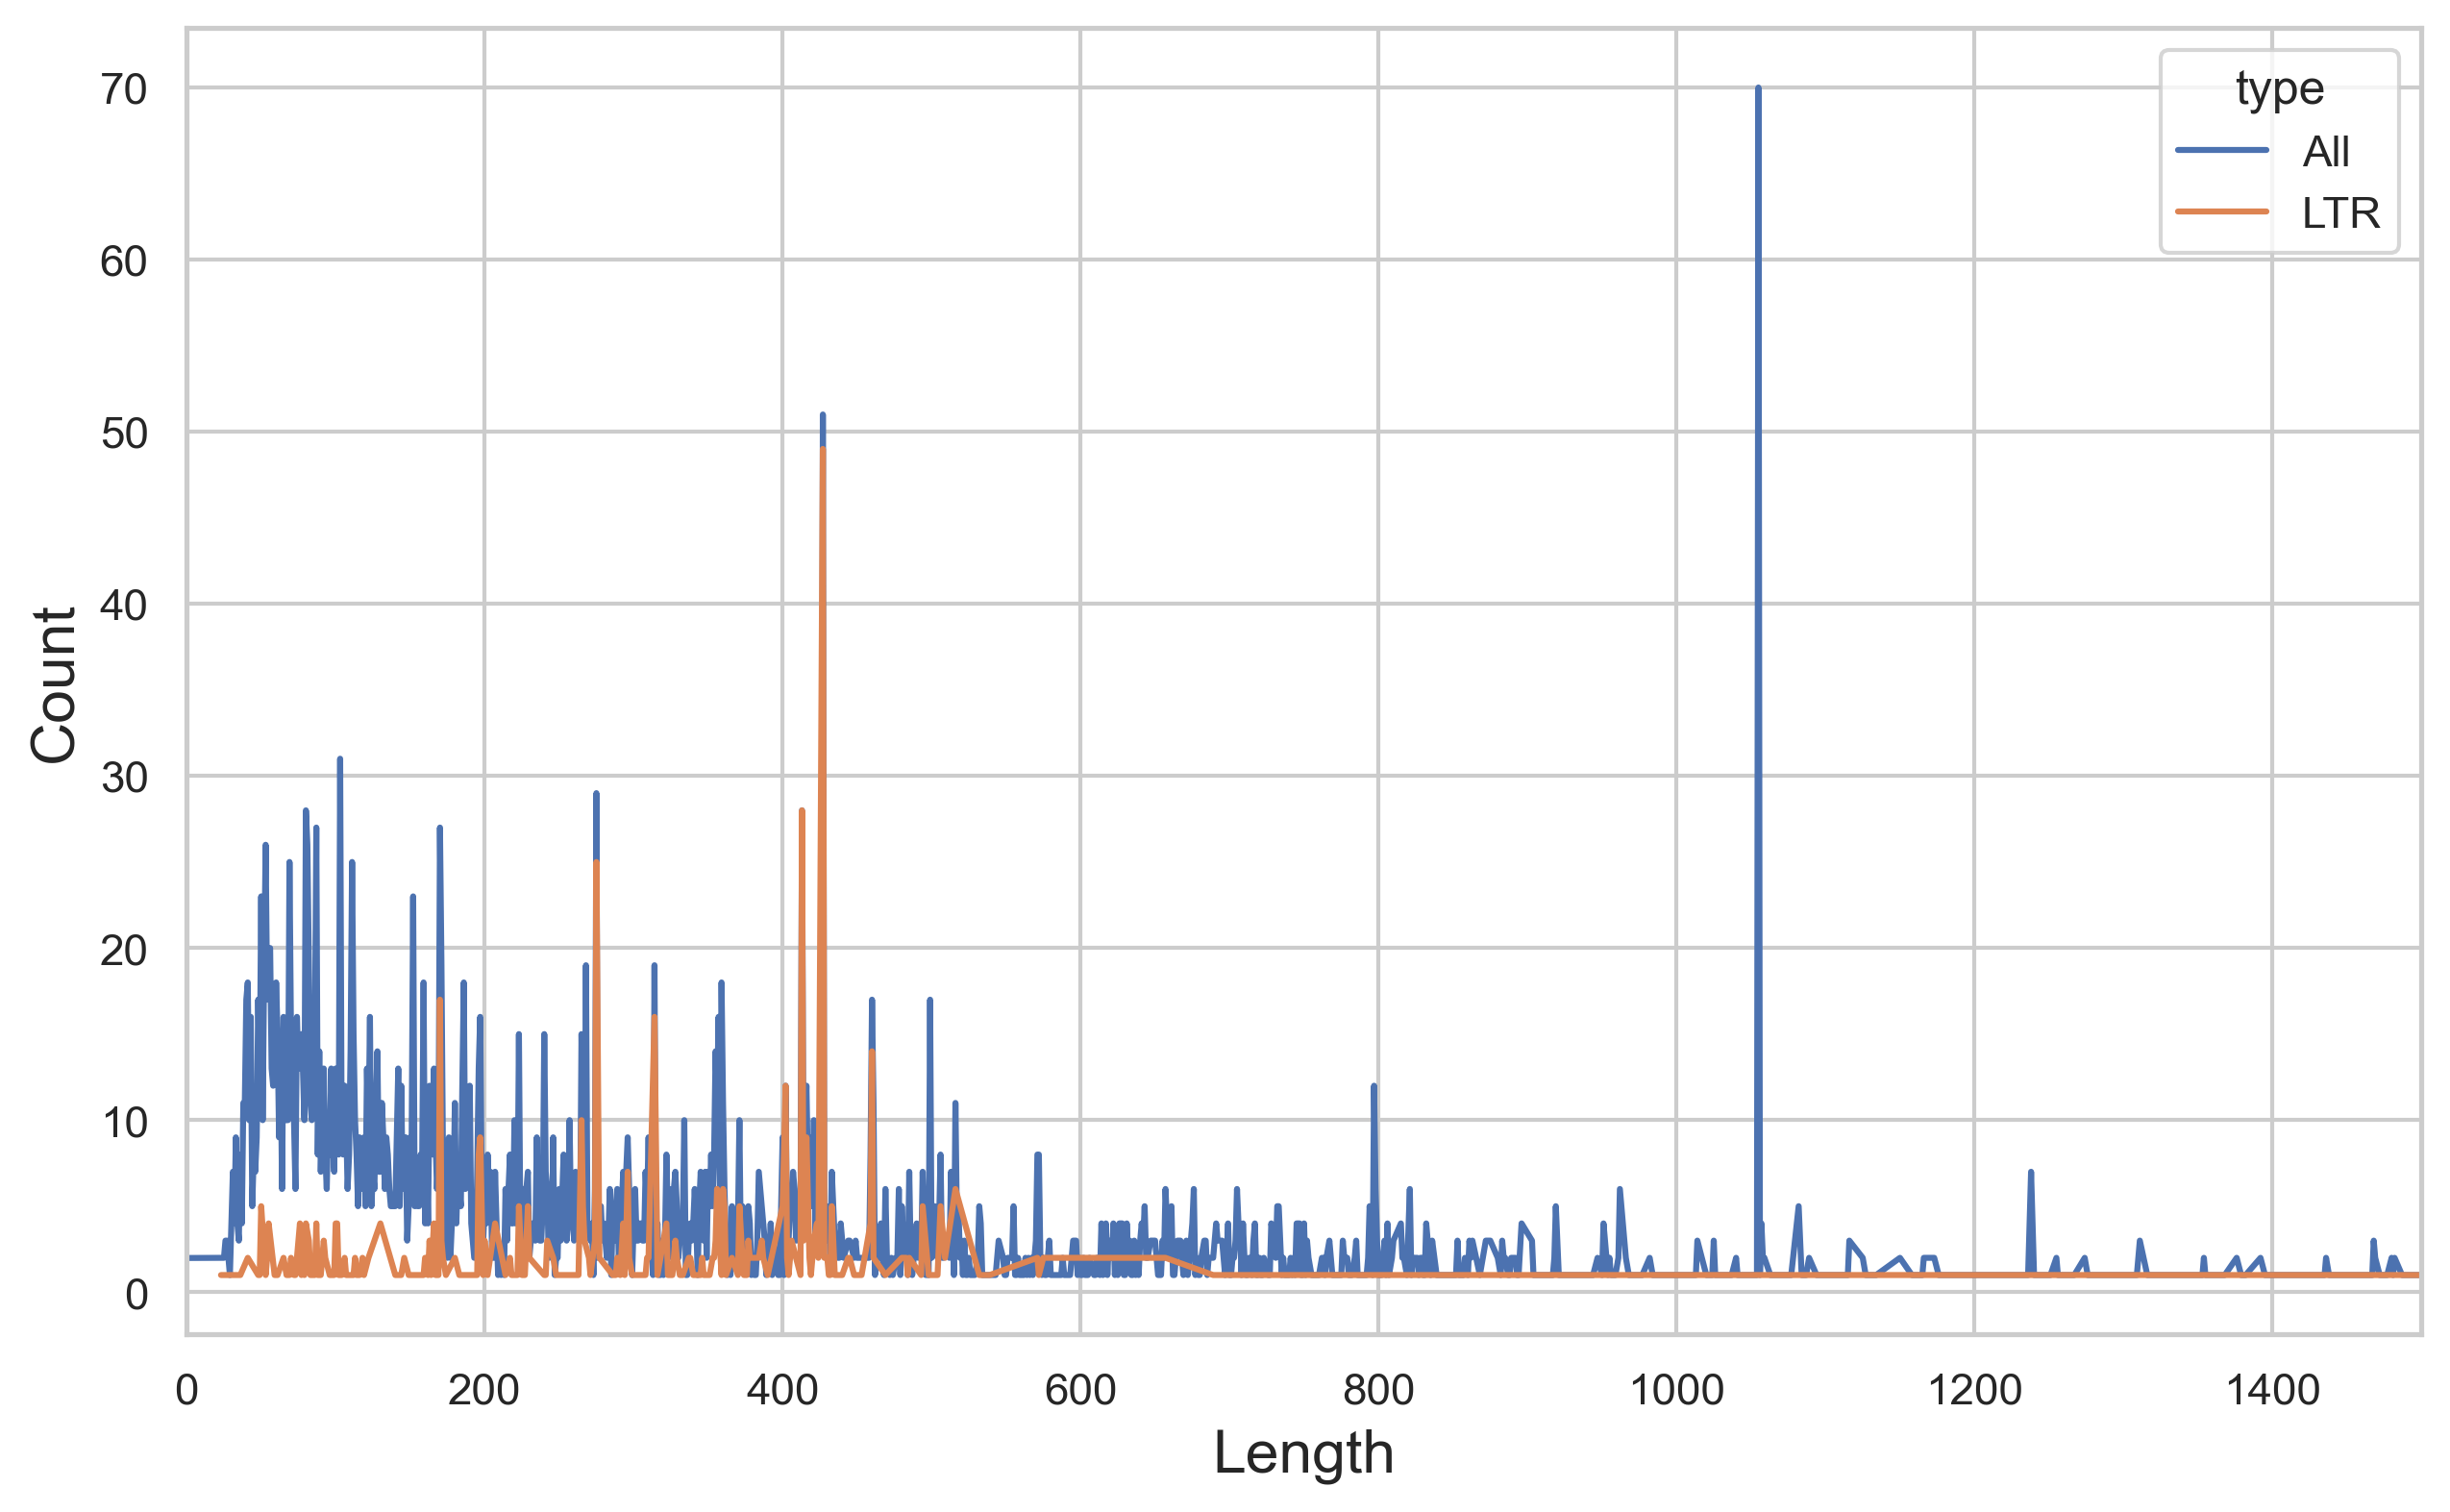

In [ ]:
df = pd.DataFrame(columns=["x", "y", "type"], dtype=float)
for row in totalSortedCounterList:
    df = df.append({"x": row[0], "y": row[1], "type": "All"}, ignore_index=True)
for row in LTRSortedCounterList:
    df = df.append({"x": row[0], "y": row[1], "type": "LTR"}, ignore_index=True)

df.fillna(np.nan, inplace=True)
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")
sns.lineplot(data=df, x="x", y="y", hue="type")
ax.set_xlabel("Length", size=15)
ax.set_ylabel("Count", size=15)
ax.set_xlim(0, 1500)

In [ ]:
# Dfam ref sequence 
# dfamSeqLenList = [ i.endIdx - i.startIdx for i in dfamPositionList ]
# getSequenceLengthAnalsis(dfamSeqLenList)

In [ ]:
# Repeat sequence
# repeatFragmentLenList = [ i.endIdx - i.startIdx for i in repeatPositionList ]
# getSequenceLengthAnalsis(repeatFragmentLenList)

In [ ]:
# def consensusSeqSimilarity(consensusSeq, seqDf):
#     print("hihi", len(seqDf))
#     seqSimilarityList = []
#     for targetSeq in seqDf:
#         alignments = pairwise2.align.globalxx(targetSeq, consensusSeq)
#         targetLength = len(targetSeq)
#         similarityPercentage = round(alignments[0].score / targetLength, 2)
#         seqSimilarityList.append(similarityPercentage)
#     return seqSimilarityList

# repeatMatchIdxList = []
# for idx, value in enumerate(RDrepeatMatchList):
#     if value == True:
#         repeatMatchIdxList.append(idx)
# repeatBasePositionList = [repeatPositionList[i] for i in repeatMatchIdxList]
# repeatSeqDf = pd.DataFrame(columns=['startIdx','endIdx', 'length', 'seq'])
# for i in repeatBasePositionList:
#     repeatSeqDf = repeatSeqDf.append({'startIdx':i.startIdx ,'endIdx': i.endIdx, 'length': (i.endIdx- i.startIdx), 'seq': str(parseFastaA[0][i.startIdx:i.endIdx])}, ignore_index=True)
# conParseFasta = parseFasta(
#     "DF0001696_ROO_LTR",
#     "./Evaluation/Source/DF0001696_ROO_LTR.fa",
#     "*",
#     matchMode=False,
# )
# consensusSeq = conParseFasta[0].upper()
# repeatDf = pd.read_csv('./Evaluation/Source/chrX_ROO_LTR_repeatSeq.csv')
# seqDf = repeatDf["seq"]
# seqSimilarityList = consensusSeqSimilarity(consensusSeq, seqDf)
# pd.Series(seqSimilarityList).describe()

In [ ]:
# Test cutter A
repeatPositionListA = seqA.getRepeatPositionList()
dfamA = DfamEvaluation(repeatPositionListA)
repeatPositionLookupDicA = dfamA.positionBucketClassifier()
dfamPositionListA = dfamA.getDfamPositionList()
dfamPositionLookupDicA = dfamA.positionBucketClassifier()
DRrepeatMatchListA, DRmatchedFamilyAccListA, DRmatchedFamilyNameListA = dfamA.checkDfamMatchWithRepeat()

In [ ]:
totalLen = len(DRrepeatMatchListA)
matchLenA = len(list(filter(lambda x: x, DRrepeatMatchListA)))
ratio = matchLenA / totalLen
print(f"matchCount:{matchLenA}\tdfamCount:{totalLen}\tRatio:{ratio}")

matchCount:593	dfamCount:602	Ratio:0.9850498338870431


In [ ]:
# Test cutter B
repeatPositionListB = seqB.getRepeatPositionList()
dfamB = DfamEvaluation(repeatPositionListB)
repeatPositionLookupDicB = dfamB.positionBucketClassifier()
dfamPositionListB = dfamB.getDfamPositionList()
dfamPositionLookupDicB = dfamB.positionBucketClassifier()
DRrepeatMatchListB, DRmatchedFamilyAccListB, DRmatchedFamilyNameListB = dfamB.checkDfamMatchWithRepeat()

In [ ]:
totalLen = len(DRrepeatMatchListB)
matchLenB = len(list(filter(lambda x: x, DRrepeatMatchListB)))
ratio = matchLenB / totalLen
print(f"matchCount:{matchLenB}\tdfamCount:{totalLen}\tRatio:{ratio}")

matchCount:255	dfamCount:602	Ratio:0.42358803986710963


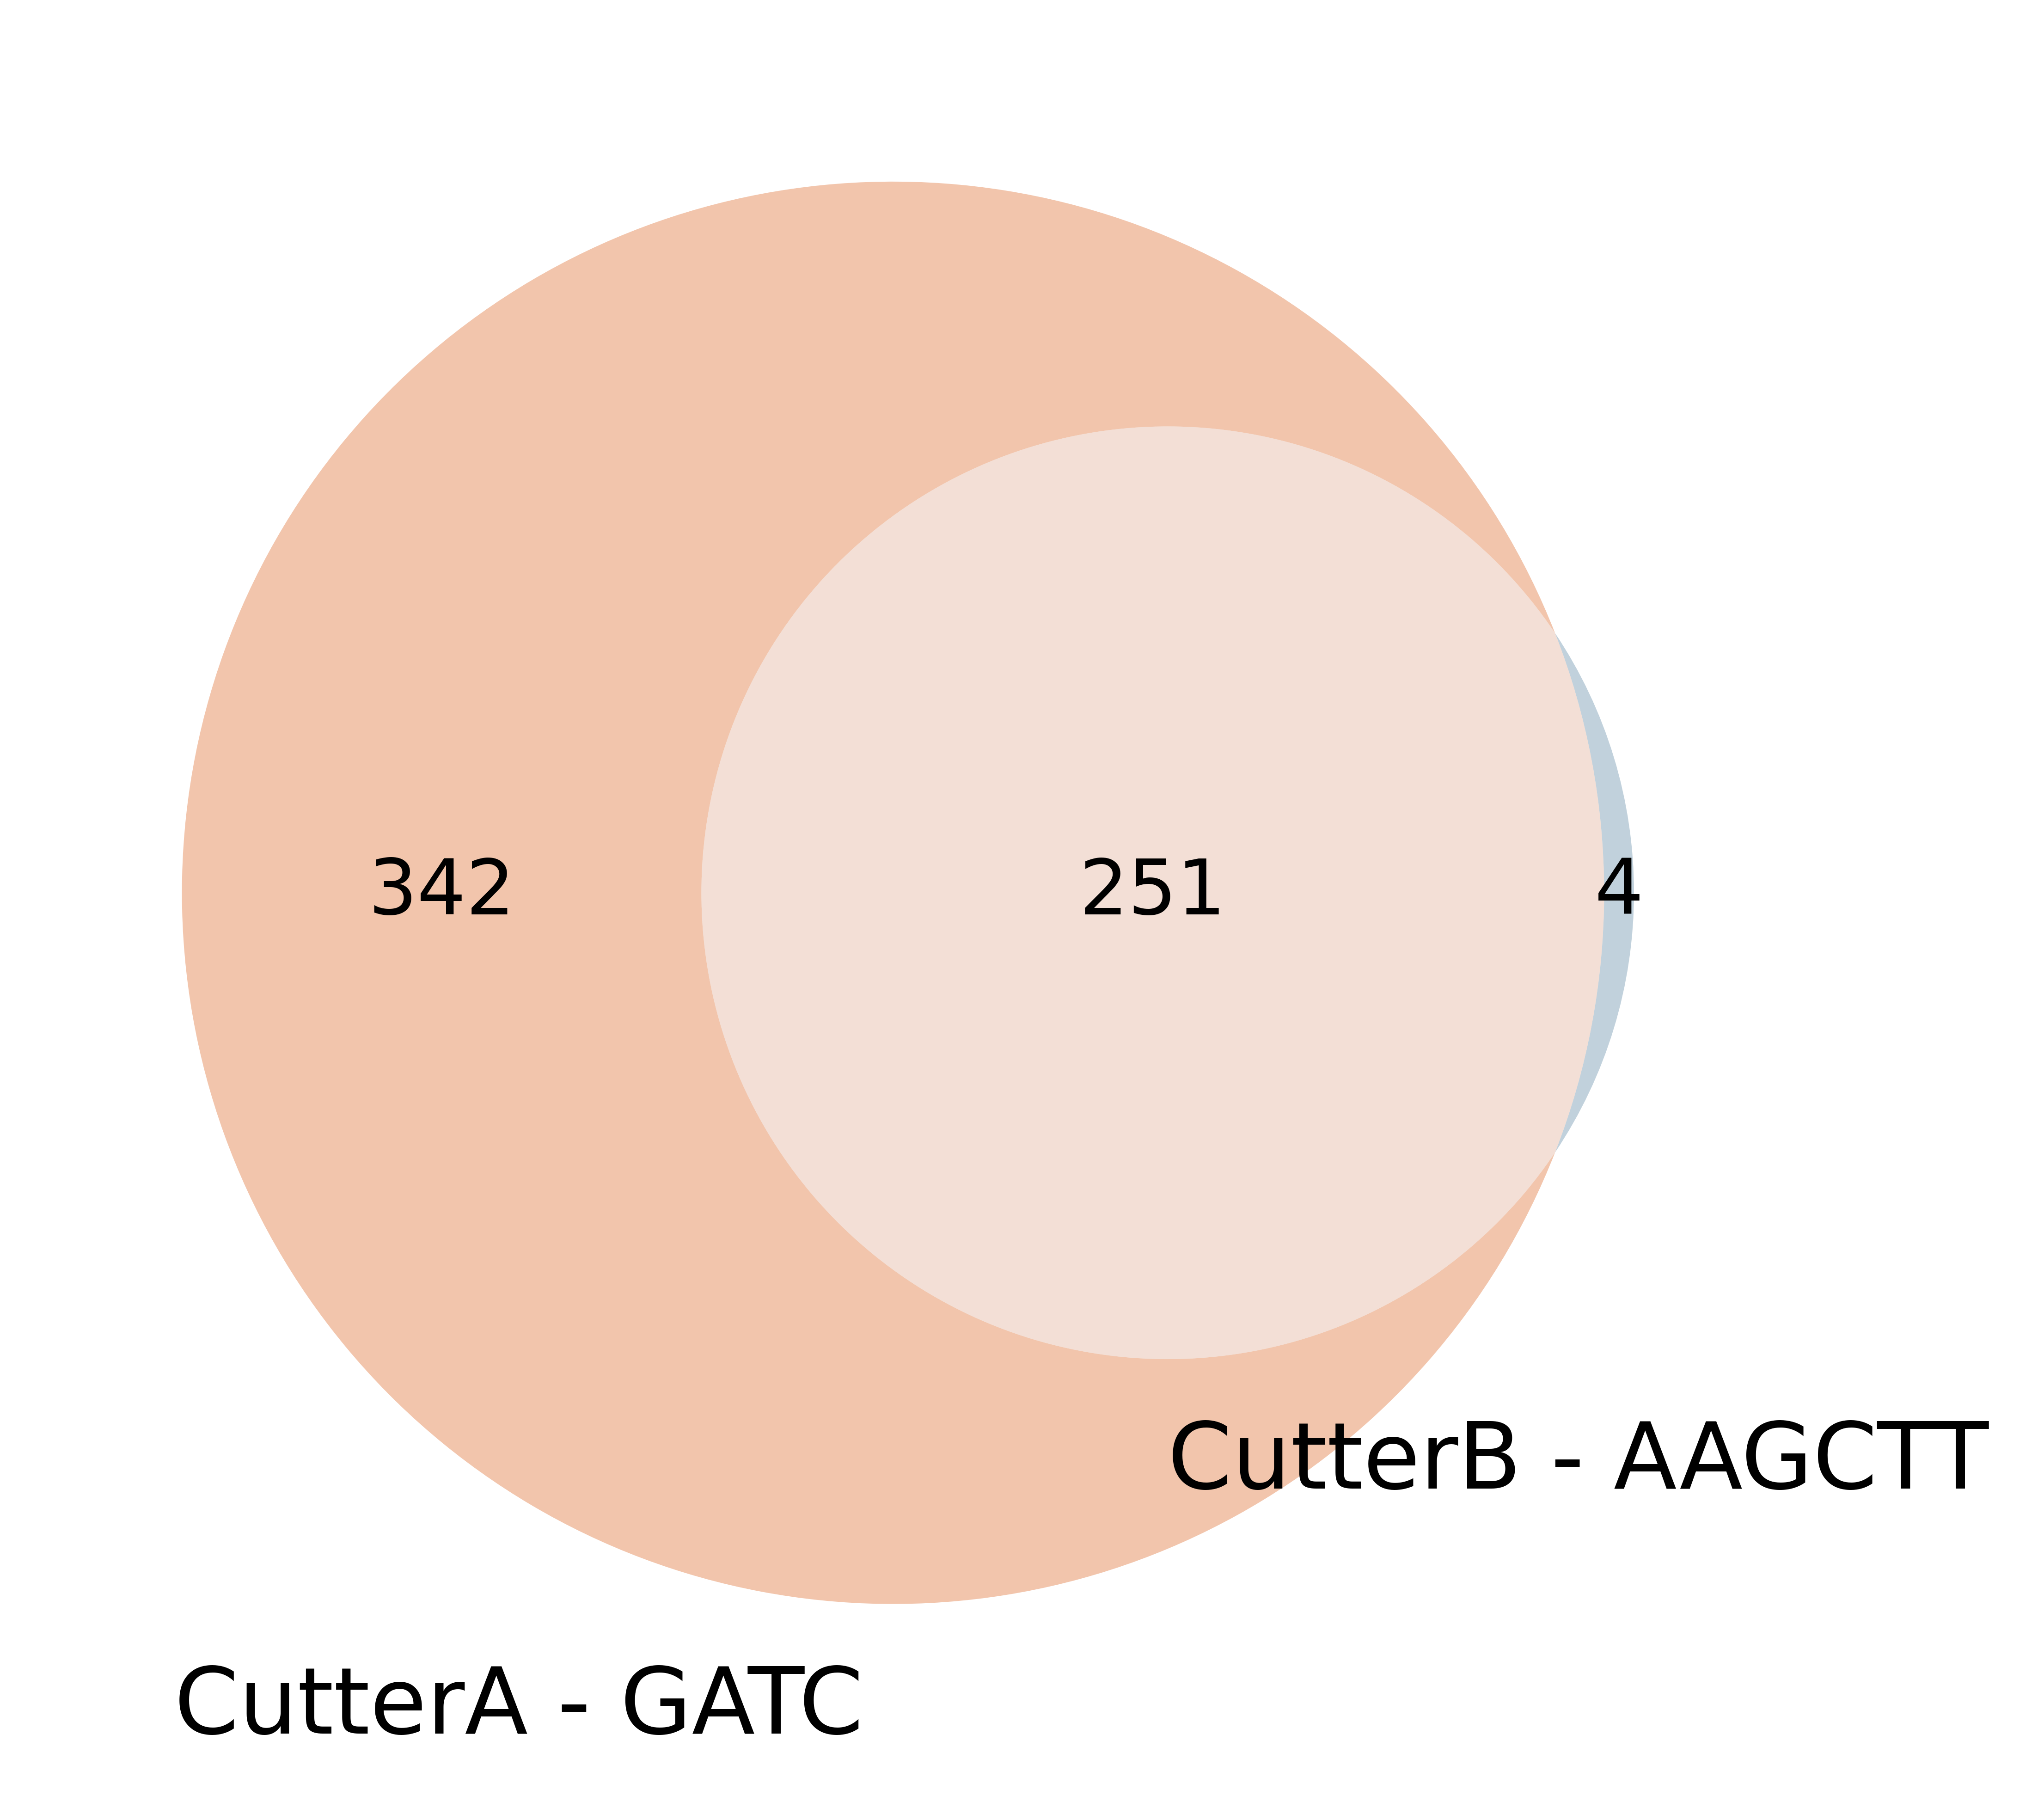

In [ ]:
total = 597
middle = matchLenA+matchLenB - total
plt.figure(linewidth=10, facecolor="white", dpi=1200)
# plt.figure(linewidth=10, facecolor="white")
v = venn2(subsets = (matchLenA-middle, matchLenB-middle, middle), set_labels = (f'CutterA - {cutterA} ', f'CutterB - {cutterB}'), set_colors=(colorA, colorB))
plt.show()
